# NLP Final Project - Recipe Recommender

#### Group 2 Members: Emily Tseng, Rongyu Lin

Project Scope
- Part I -  Data source
- Part II - Access-to-data 
- Part III - Define cosine similarity function
- Part IV - Using Tf-Idf Vectorizer to vectorize the ingredients
- Part V - Build a recipe recommender 

In [1]:
# Import the required libraries 
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup 
import requests
import time 

## Part I -  Data source

We will be using requests and Beautiful Soup methods to pull content from static HTML pages (Jamie Oliver’s cooking website: https://www.jamieoliver.com/). 

In [2]:
# Define the url in python 
url = "https://www.jamieoliver.com/recipes/category/course/mains/"

In [3]:
# Fetching html from the website
page = requests.get(url)
# BeautifulSoup enables to find the elements/tags in a webpage 
soup = BeautifulSoup(page.text, "html.parser")

In [4]:
print(soup)

<!DOCTYPE html>

<html class="country-code-default" lang="en">
<head>
<meta charset="utf-8"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="width=device-width, initial-scale=1" name="viewport"/>
<link crossorigin="" href="https://cdn.jamieoliver.com" rel="preconnect"/>
<link crossorigin="" href="//img.jamieoliver.com" rel="preconnect"/>
<link crossorigin="" href="//fonts.googleapis.com" rel="preconnect"/>
<link crossorigin="" href="//ajax.googleapis.com" rel="preconnect"/>
<!-- Meta -->
<title>Mains Recipes | Jamie Oliver</title>
<meta content="A good, balanced &amp; healthy main meal can be a real show-stopper; check out our incredible selection of main course recipes at JamieOliver.com" name="description">
<meta content="Jamie Oliver, recipes, food, pasta, lasagne, videos" name="keywords">
<meta content="JamieOliver.com" name="author">
<meta content="050179ea6bc8e9e62d0fd9edcc154d4a" name="p:domain_verify"/>
<meta content="27994914806" property="fb:pages"/> <l

In [5]:
links = []
for link in soup.find_all('a'):
    links.append(link.get('href'))
print(links[100:105])

['/recipes/pork-recipes/tomato-red-wine-chorizo-risotto/', '/recipes/stew-recipes/venison-shanks-juniper-amp-redcurrants/', '/recipes/vegetables-recipes/roasted-brassicas-with-puy-lentils-halloumi/', '/recipes/fish-recipes/quick-fish-cakes/', '/recipes/fish-recipes/asian-salmon-sweet-potato-traybake/']


In [6]:
# Filtering the urls to only ones containing recipes 
import pandas as pd
recipe_urls = pd.Series([a.get("href") for a in soup.find_all("a")])
recipe_urls  = (recipe_urls[(recipe_urls.str.count("-")>0) & 
                          (recipe_urls.str.contains("/recipes/")==True) & 
                          (recipe_urls.str.contains("-recipes/")==True) & 
                          (recipe_urls.str.contains("course")==False) & 
                          (recipe_urls.str.contains("books")==False) & 
                          (recipe_urls.str.endswith("recipes/")==False)].unique())
df = pd.DataFrame(recipe_urls)

In [7]:
len(df)

857

In [8]:
df = df.rename(columns = {0:"recipe_urls"})

In [9]:
df["recipe_urls"] = "https://www.jamieoliver.com" + df["recipe_urls"].astype("str")

In [10]:
df.head()

,recipe_urls
0,https://www.jamieoliver.com/recipes/duck-recip...
1,https://www.jamieoliver.com/recipes/vegetable-...
2,https://www.jamieoliver.com/recipes/pasta-reci...
3,https://www.jamieoliver.com/recipes/vegetable-...
4,https://www.jamieoliver.com/recipes/chicken-re...


## Part II - Access-to-data 

- Obtain URLs to recipe page on Jamie Oliver’s cooking website 
- Define functions to find recipe attributes from HTML pagess: 
1. Recipe Name
2. Ingredients
3. Serving Size 
4. Cooking Time
5. Difficulty   

In [12]:
recipe_df = pd.read_csv("/Users/Emily/Desktop/NLP/recipe_urls.csv")
attribs = ['recipe_name', 'serves', 'cooking_time', 'difficulty', 'ingredients']

In [13]:
headers = {'User-Agent': "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36"}

class JamieOliver():
    """ This class will output the recipe details. Recipes have the
    following properties:
    Attributes:
        url: The url of the recipe on Jamie Oliver site.
    Methods:
        Ingredients: Recipe ingredients.
        Cooking time: What it says on the tin.
        Difficulty: Recipe difficulty.
        Serves: How many people the recipe serves.
    """
    def __init__(self, url):
        self.url = url 
        self.soup = BeautifulSoup(requests.get(url, headers=headers).content, 'html.parser')
    
    def recipe_name(self):
        """ Locates the recipe title """
        # Some of the urls are not recipe urls so to avoid errors we use try/except 
        try:
            return self.soup.find('h1').text.strip()
          # return self.soup.select('ht.hidden-xs')[0].text.strip()
        except: 
            return np.nan
        
    def serves(self):
        """ Locates the number of people the meal serves """
        try:
            return self.soup.find('div', {'class': 'recipe-detail serves'}).text.split(' ',1)[1]
        except:
            return np.nan 

    def cooking_time(self):
        """ Locates the cooking time (in mins or hours and mins) """
        try:
            return self.soup.find('div', {'class': 'recipe-detail time'}).text.split('In')[1]
        except:
            return np.nan


    def difficulty(self):
        """ Locates the cooking difficulty """
        try:
            return self.soup.find('div', {'class': 'col-md-12 recipe-details-col remove-left-col-padding-md'}).text.split('Difficulty')[1]
        except:
            return np.nan

    def ingredients(self):
        """ Creating a vector containing the ingredients of the recipe """
        try:
            ingredients = [] 
            for li in self.soup.select('.ingred-list li'):
                ingred = ' '.join(li.text.split())
                ingredients.append(ingred)
            return ingredients
        except:
            return np.nan

In [14]:
# For each url (i) we add the attribute data to the i-th row
temp = pd.DataFrame(columns=attribs)
for i in range(0,len(recipe_df['recipe_urls'])):
    url = recipe_df['recipe_urls'][i]
    recipe_scraper = JamieOliver(url)
    temp.loc[i] = [getattr(recipe_scraper, attrib)() for attrib in attribs]
    if i % 25 == 0:
        print(f'Step {i} completed')
    # time.sleep(np.random.randint(1,5,1))

Step 0 completed
Step 25 completed
Step 50 completed
Step 75 completed
Step 100 completed
Step 125 completed
Step 150 completed
Step 175 completed
Step 200 completed
Step 225 completed
Step 250 completed
Step 275 completed
Step 300 completed
Step 325 completed
Step 350 completed
Step 375 completed
Step 400 completed
Step 425 completed
Step 450 completed
Step 475 completed
Step 500 completed
Step 525 completed
Step 550 completed
Step 575 completed
Step 600 completed
Step 625 completed
Step 650 completed
Step 675 completed
Step 700 completed
Step 725 completed
Step 750 completed
Step 775 completed
Step 800 completed
Step 825 completed
Step 850 completed


In [15]:
# Put all the data into the same dataframe
temp['recipe_urls'] = recipe_df['recipe_urls']
columns = ['recipe_urls'] + attribs
temp = temp[columns]
JamieOliver_df = temp
# JamieOliver_df.to_csv(r"/Users/Emily/Desktop/NLP/JamieOliver_full.csv", index=False)

In [16]:
import pandas as pd


JamieOliver_full = pd.read_csv("/Users/Emily/Desktop/NLP/JamieOliver_full.csv")

In [17]:
JamieOliver_full.head()

,recipe_urls,recipe_name,serves,cooking_time,difficulty,ingredients
0,https://www.jamieoliver.com/recipes/duck-recip...,Roast duck with Marsala gravy,6 ...,2 hours 20 minutes ...,Not too tricky ...,"['1 x 1.6kg whole duck', '2 heaped teaspoons C..."
1,https://www.jamieoliver.com/recipes/vegetable-...,Best-ever Brussels sprouts,6 as a side ...,30 minutes ...,Not too tricky ...,"['800 g Brussels sprouts', '2 higher-welfare C..."
2,https://www.jamieoliver.com/recipes/pasta-reci...,Beautiful courgette carbonara,6 ...,20 minutes ...,Not too tricky ...,"['6 medium green and yellow courgettes', '500 ..."
3,https://www.jamieoliver.com/recipes/vegetable-...,Roasted black bean burgers,4 ...,40 minutes ...,Not too tricky ...,"['1½ red onions', '200 g mixed mushrooms', '10..."
4,https://www.jamieoliver.com/recipes/chicken-re...,Chicken & tofu noodle soup,2 ...,1 hour 15 minutes plus chilling overnight ...,Not too tricky ...,"['2 shallots', '2 cloves of garlic', '2 cm pie..."


In [18]:
len(JamieOliver_full)

857

## Part III - Define cosine similarity function

Cosine similarity is a measure of similarity between two sequences of vectors. The closer to 1, the more similar of two vectors, and also represents the more similar of two recipes.

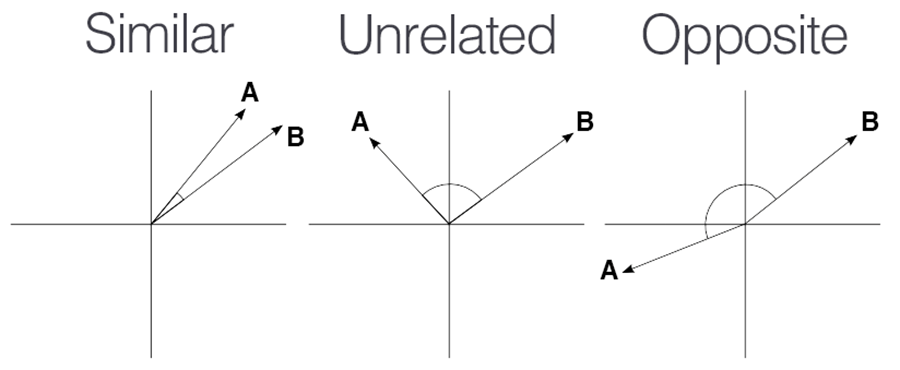

In [19]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
ingredients = JamieOliver_full[['recipe_name','ingredients']]
ingredients.head()

,recipe_name,ingredients
0,Roast duck with Marsala gravy,"['1 x 1.6kg whole duck', '2 heaped teaspoons C..."
1,Best-ever Brussels sprouts,"['800 g Brussels sprouts', '2 higher-welfare C..."
2,Beautiful courgette carbonara,"['6 medium green and yellow courgettes', '500 ..."
3,Roasted black bean burgers,"['1½ red onions', '200 g mixed mushrooms', '10..."
4,Chicken & tofu noodle soup,"['2 shallots', '2 cloves of garlic', '2 cm pie..."


In [21]:
#Lets vectorize all these titles
from sklearn.feature_extraction.text import CountVectorizer

#initialize vectorizer
vect = CountVectorizer(analyzer = 'word', ngram_range = (1,2), stop_words = 'english', min_df = 0.002) #min_df = rare words, max_df = most used words
#ngram_range = (1,2) - if used more than  1(value), lots of features or noise

#Fit into the title
vect.fit(ingredients['ingredients'])
ingredients_matrix = vect.transform(ingredients['ingredients'])
ingredients_matrix.shape

(857, 4470)

In [22]:
features = vect.get_feature_names()
features

['00',
 '00 flour',
 '10',
 '10 black',
 '10 cloves',
 '10 curry',
 '10 fresh',
 '10 large',
 '10 minute',
 '10 sprigs',
 '10 unsalted',
 '100',
 '100 almonds',
 '100 baby',
 '100 breadcrumbs',
 '100 brown',
 '100 butter',
 '100 ciabatta',
 '100 cooked',
 '100 crème',
 '100 dried',
 '100 fat',
 '100 fine',
 '100 fresh',
 '100 freshly',
 '100 frozen',
 '100 goat',
 '100 green',
 '100 higher',
 '100 mixed',
 '100 ml',
 '100 mushrooms',
 '100 parmesan',
 '100 peas',
 '100 plain',
 '100 podded',
 '100 quality',
 '100 ripe',
 '100 runner',
 '100 silken',
 '100 soft',
 '100 spinach',
 '100 stale',
 '100 sugar',
 '100 unsalted',
 '100 walnuts',
 '100 watercress',
 '100 white',
 '100g',
 '10cm',
 '115',
 '115 plain',
 '12',
 '12 black',
 '12 fresh',
 '12 higher',
 '12 large',
 '12 ripe',
 '12 scallops',
 '12 slices',
 '12 small',
 '120',
 '120 firm',
 '120 free',
 '120 ml',
 '120 panko',
 '120 salmon',
 '120 skinless',
 '120 trout',
 '125',
 '125 baby',
 '125 ball',
 '125 balls',
 '125 ml',
 '

In [23]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim_ingredients = cosine_similarity(ingredients_matrix, ingredients_matrix)
cosine_sim_ingredients.shape

(857, 857)

In [24]:
ingredients_id = 100
ingredients['ingredients'].iloc[ingredients_id]

"['25 g sun-dried tomatoes', '2 dates', '50 g walnuts', '4 courgettes', '4-5 cauliflower florets', '½ a red onion', '1 small clove of garlic', '1 sprig of fresh rosemary', '½ a small red chilli', '½ a carrot', '½ a stick of celery', '¼ of a red pepper', '½ a beetroot', '225 g cherry tomatoes', '½ lemon', '½ a bunch of fresh flat-leaf parsley', '½ a bunch of fresh basil']"

In [25]:
import numpy as np
feature_array = np.squeeze(ingredients_matrix[ingredients_id].toarray()) #squeeze activity matrix into array
idx = np.where(feature_array > 0)
idx[0]
[features[x] for x in idx[0]]

['225',
 '25',
 '50',
 '50 walnuts',
 'basil',
 'beetroot',
 'bunch',
 'bunch fresh',
 'carrot',
 'cauliflower',
 'cauliflower florets',
 'celery',
 'celery red',
 'cherry',
 'cherry tomatoes',
 'chilli',
 'clove',
 'clove garlic',
 'courgettes',
 'dates',
 'dried',
 'dried tomatoes',
 'flat',
 'flat leaf',
 'florets',
 'fresh',
 'fresh basil',
 'fresh flat',
 'fresh rosemary',
 'garlic',
 'garlic sprig',
 'leaf',
 'leaf parsley',
 'lemon',
 'lemon bunch',
 'onion',
 'onion small',
 'parsley',
 'parsley bunch',
 'pepper',
 'red',
 'red chilli',
 'red onion',
 'red pepper',
 'rosemary',
 'small',
 'small clove',
 'small red',
 'sprig',
 'sprig fresh',
 'stick',
 'stick celery',
 'sun',
 'sun dried',
 'tomatoes',
 'tomatoes lemon',
 'walnuts']

In [26]:
idx[0]

array([ 186,  194,  339,  366,  562,  618,  736,  743,  818,  845,  846,
        852,  864,  909,  910,  946, 1097, 1098, 1188, 1278, 1326, 1351,
       1525, 1526, 1530, 1582, 1584, 1595, 1614, 1645, 1693, 2077, 2079,
       2137, 2147, 2611, 2632, 2766, 2774, 2863, 3163, 3168, 3175, 3177,
       3260, 3560, 3568, 3584, 3700, 3701, 3750, 3751, 3820, 3821, 4172,
       4193, 4330], dtype=int64)

In [27]:
#Cosine similarity with other similar titles
n = 15 #how many books to be recommended
top_n_idx = np.flip(np.argsort(cosine_sim_ingredients[ingredients_id,]), axis = 0)[0:n]
top_n_sim_values = cosine_sim_ingredients[ingredients_id, top_n_idx]
top_n_sim_values

array([1.        , 0.48602144, 0.46333786, 0.44918226, 0.43239268,
       0.4272367 , 0.40533961, 0.40528187, 0.40016337, 0.3981824 ,
       0.3962947 , 0.39489242, 0.39392809, 0.39003423, 0.38779328])

In [28]:
#find top n with values > 0
top_n_idx = top_n_idx[top_n_sim_values > 0]
#Matching ingredients
ingredients['ingredients'].iloc[top_n_idx]

100    ['25 g sun-dried tomatoes', '2 dates', '50 g w...
217    ['50 g raisins', '3 tablespoons balsamic vineg...
257    ['1 bulb of garlic', '½ a red cabbage , (400g)...
34     ['½ a bunch of fresh oregano', '½ a bunch of f...
247    ['150 g dark bulgur wheat', '150 g green or ye...
429    ['2 tablespoons capers', '4 tablespoons rosé w...
232    ['35 g pancetta', '2 stalks of celery', '1 sma...
677    ['2 red onions', '1 whole bulb garlic', '3 car...
238    ['4 quality anchovies in oil', '½ a lemon', '½...
519    ['1 x 2 kg whole salmon , gutted, gills remove...
681    ['500 g mixed red and yellow cherry tomatoes',...
220    ['1.5 kg beef brisket', '1 large stick of cinn...
636    ['2 red onions', '1 carrot', '1 leek', '1 red ...
189    ['5 shallots', '4 cloves of garlic', '200 g gr...
478    ['1 yellow pepper', '1 red pepper', '1 red chi...
Name: ingredients, dtype: object

In [29]:
ingredient = ingredients['ingredients']
indices = pd.Series(ingredients.index, index = ingredients['ingredients']) #converting all titles into a Series

In [30]:
def return_sim_ingredients(ingredients_id, ingredients_matrix, vectorizer, top_n = 10):
    
    # generate sim matrix
    sim_matrix = cosine_similarity(ingredients_matrix, ingredients_matrix)
    features = vectorizer.get_feature_names()

    top_n_idx = np.flip(np.argsort(sim_matrix[ingredients_id,]),axis=0)[0:top_n]
    top_n_sim_values = sim_matrix[ingredients_id, top_n_idx]
    
    # find top n with values > 0
    top_n_idx = top_n_idx[top_n_sim_values > 0]
    scores = top_n_sim_values[top_n_sim_values > 0]
    
    
    # find features from the vectorized matrix
    sim_ingredients_idx = ingredients['ingredients'].iloc[top_n_idx].index
    words = []
    for ingredients_idx in sim_ingredients_idx:
        try:
            feature_array = np.squeeze(ingredients_matrix[ingredients_idx,].toarray())
        except:
            feature_array = np.squeeze(ingredients_matrix[book_idx,])
        idx = np.where(feature_array > 0)
        words.append([" , ".join([features[i] for i in idx[0]])])
        
    # collate results
    res = pd.DataFrame({"ingredients_title" : ingredients['ingredients'].iloc[ingredients_id],
           "sim_ingredients": ingredients['ingredients'].iloc[top_n_idx].values,"words":words,
           "scores":scores}, columns = ["ingredients_title","sim_ingredients","scores","words"])
    
    return res

In [31]:
vect = CountVectorizer(analyzer='word',ngram_range=(1,2),stop_words='english', min_df = 0.001)
vect.fit(ingredients['ingredients'])
ingredients_matrix = vect.transform(ingredients['ingredients'])
print(ingredients['ingredients'][10])
return_sim_ingredients(10,ingredients_matrix,vect,top_n=10)

['olive oil', '2 shallots', '1 clove of garlic', '80 g higher-welfare chorizo', '½ a bunch of fresh flat-leaf parsley , (15g)', '750ml–1 litre of organic chicken or vegetable stock', '1 x 400 g tin of quality plum tomatoes', '300 g risotto rice', '200 ml red wine', '50 g Parmesan cheese , plus extra to serve']


,ingredients_title,sim_ingredients,scores,words
0,"['olive oil', '2 shallots', '1 clove of garlic...","['olive oil', '2 shallots', '1 clove of garlic...",1.000000,"[15g , 15g 750ml , 200 , 200 ml , 300 , 300 ri..."
1,"['olive oil', '2 shallots', '1 clove of garlic...",['4 rashers of higher-welfare smoked streaky b...,0.421295,"[125 , 125 ml , 300 , 300 savoy , 400 , 400 ti..."
2,"['olive oil', '2 shallots', '1 clove of garlic...","['1 bulb of garlic', '½ a bunch of fresh thyme...",0.410016,"[100 , 100 unsalted , 150 , 150 ml , 150 parme..."
3,"['olive oil', '2 shallots', '1 clove of garlic...","['4 cloves of garlic', '1 teaspoon smoked papr...",0.386554,"[15g , 15g extra , 15g olive , 1kg , 1kg table..."
4,"['olive oil', '2 shallots', '1 clove of garlic...","['1 clove of garlic', '2 sticks of celery', '4...",0.385257,"[400 , 400 broccoli , broccoli , broccoli bunc..."
5,"['olive oil', '2 shallots', '1 clove of garlic...","['400 g tagliatelle', '150 g mushrooms', '1 cl...",0.375908,"[100 , 100 crème , 150 , 150 mushrooms , 400 ,..."
6,"['olive oil', '2 shallots', '1 clove of garlic...","['PASTA', '1 organic vegetable stock cube', '1...",0.372616,"[15g , 15g 400 , 15g ripe , 15g salad , 20 , 2..."
7,"['olive oil', '2 shallots', '1 clove of garlic...","['1 x 1.2 kg cuttlefish , cleaned, skin and tr...",0.361506,"[15g , 15g large , 30 , 30 unsalted , 300 , 30..."
8,"['olive oil', '2 shallots', '1 clove of garlic...","['FILLING', '400 g higher-welfare minced pork'...",0.361506,"[100 , 100 parmesan , 200 , 200 ml , 400 , 400..."
9,"['olive oil', '2 shallots', '1 clove of garlic...","['500 g ripe tomatoes', '2 cloves of garlic', ...",0.351640,"[200 , 200 baby , 200 olives , 400 , 400 tin ,..."


## Part IV: Using Tf-Idf Vectorizer to vectorize the ingredients

Our first step is to convert all these ingredients documents into the vectors so that our machine can recognize them. Next, we used regular expression to filter out the unnecessary text. We used the tdidfvectorizer here, instead of  CountVectorizer because it will not only focuses on the frequency of words present in the corpus, but also provides the importance of the words. 

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

tf = TfidfVectorizer(analyzer = 'word', ngram_range = (1,2), token_pattern=r'(?u)\b[A-Za-z]+\b'
, stop_words = 'english')
tfidf_model = tf.fit(ingredients['ingredients'])
tfidf_matrix = tf.fit_transform(ingredients['ingredients'])
tf.get_feature_names()
# cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
# np.shape(cosine_sim)

['acacia',
 'acacia honey',
 'achiote',
 'achiote recado',
 'acorn',
 'acorn squash',
 'action',
 'action dried',
 'adobo',
 'adobo style',
 'agave',
 'agave syrup',
 'age',
 'age appetite',
 'aged',
 'aged balsamic',
 'aged caciocavallo',
 'aji',
 'aji amarillo',
 'ale',
 'ale g',
 'ale ipa',
 'ale preferably',
 'ale teaspoon',
 'allspice',
 'allspice berries',
 'allspice g',
 'allspice heaped',
 'allspice tablespoon',
 'allspice teaspoon',
 'almonds',
 'almonds blanched',
 'almonds brazils',
 'almonds bunch',
 'almonds clove',
 'almonds cloves',
 'almonds fat',
 'almonds g',
 'almonds handfuls',
 'almonds lightly',
 'almonds olive',
 'almonds oranges',
 'almonds shelled',
 'almonds small',
 'almonds sundried',
 'almonds tablespoons',
 'almonds teaspoon',
 'amarillo',
 'amarillo chilli',
 'amarillo paste',
 'american',
 'american mustard',
 'amori',
 'amori pasta',
 'ancho',
 'ancho chilli',
 'ancho chillies',
 'ancho chipotle',
 'anchovies',
 'anchovies anchovies',
 'anchovies fresh'

## Part V: Build a recipe recommender 

After we fit the TF-IDF Vectorizer, we then used it to calculate Cosine Similarity between each recipe. When users input the ingredients, our recommendation system will compute the cosine similariy between our input ingredients and the recipes in our database. And the top 10 similar recipes will be returned based on users’ preference.

In [34]:
def userInputSorting():
    ingredients_input = input("Please input ingredients you want to cook: ")
    tfidf_input = tf.transform([ingredients_input])
    cosine_sim = cosine_similarity(tfidf_input, tfidf_matrix)
    recipe_sort = cosine_sim.argsort()
    i = -1
    recommendation_list = []
    while i>=-10:
      recommendation_list.append([ingredients['recipe_name'][recipe_sort[0][i]],ingredients['ingredients'][recipe_sort[0][i]]])
      i = i-1
    recommendation_list = pd.DataFrame(recommendation_list,columns=["Recommendation recipe name", "Ingredients"])
    return recommendation_list

In [ ]:
# Input any ingredients you want to cook
result = userInputSorting()
if len(result)>0:
    print(result)    
else: 
    print("Sorry, we couldn't find any matchess.")

In [ ]:
# The results will be saved as a csv file
result.to_csv('recipes.csv', encoding='utf-8')